In [0]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd
from numpy import genfromtxt
from numpy.linalg import svd
import csv

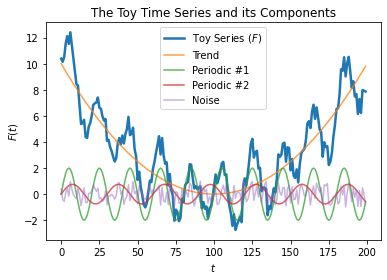

In [2]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2 = 20, 30
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

In [0]:
#from https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()

    def sigma(self):
          return self.Sigma
        
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
       

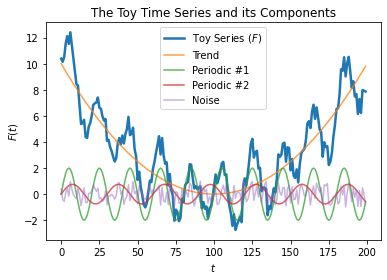

In [0]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2 = 20, 30
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

In [0]:
def plots(F, c):
    F_ssa = SSA(F, c)

    height = F_ssa.sigma()[0:c]
    x = np.arange(c)
    plt.bar(x, height)
    plt.show()

    F_ssa.reconstruct(0).plot()
    F_ssa.reconstruct(0).plot()
    F_ssa.reconstruct([1,2]).plot()
    F_ssa.reconstruct([3,4]).plot()
    F_ssa.reconstruct([4,5]).plot()
    F_ssa.orig_TS.plot(alpha=0.4)
    plt.title("")
    plt.xlabel(r"")
    plt.ylabel("")
    plt.show()

In [0]:
def val_plot(F, c):
    F_ssa = SSA(F, c)

    height = F_ssa.sigma()[0:c]
    x = np.arange(c)
    plt.scatter(x, height)

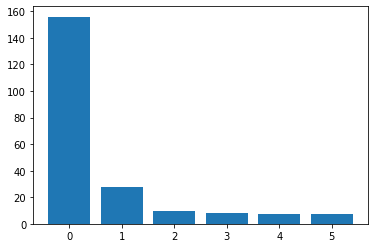

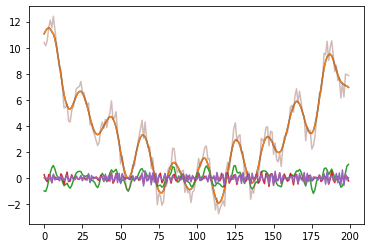

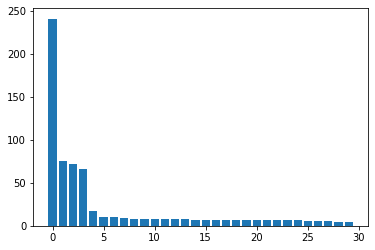

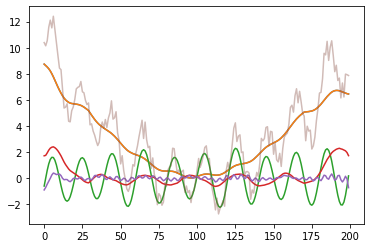

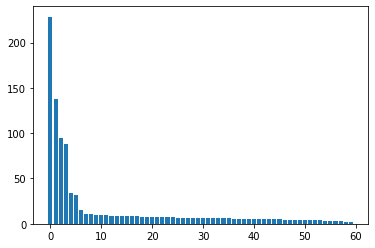

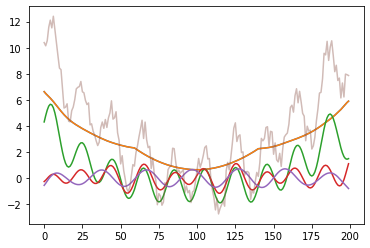

In [0]:
plots(F, 6)
plots(F, 30)
plots(F, 60)

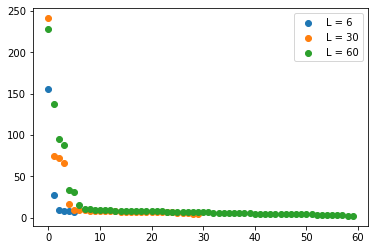

In [0]:
val_plot(F, 6)
val_plot(F, 30)
val_plot(F, 60)
plt.legend(["L = 6", "L = 30", "L = 60"])

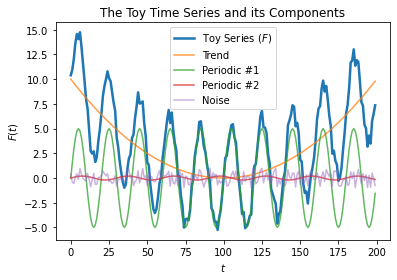

In [0]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2 = 20, 30
periodic1 = 5 * np.sin(2*pi*t/p1)
periodic2 = 0.2 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

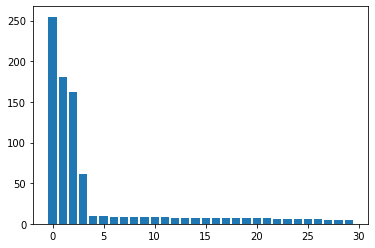

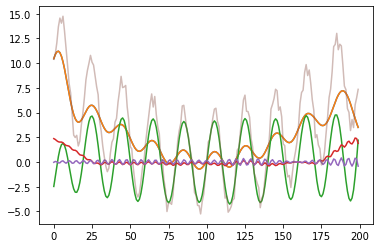

In [0]:
plots(F, 30)

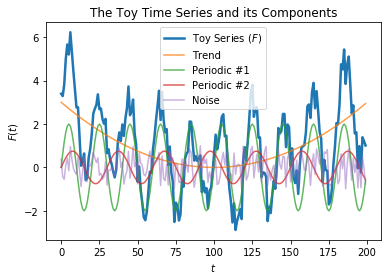

In [0]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.0003 * (t - 100)**2
p1, p2 = 20, 30
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

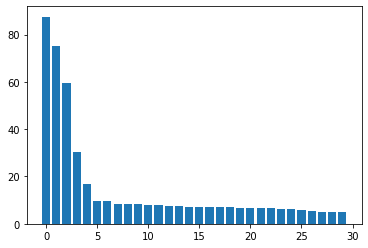

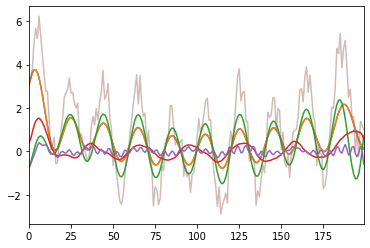

In [0]:
plots(F, 30)

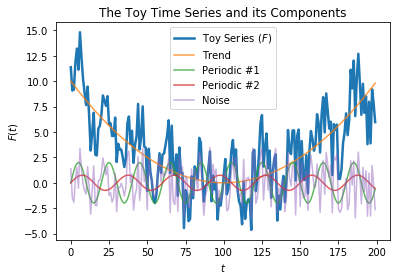

In [0]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2 = 20, 30
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 7 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

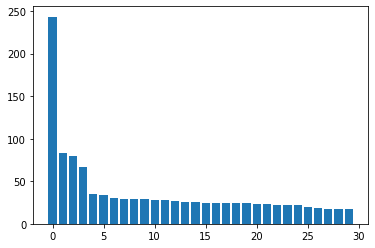

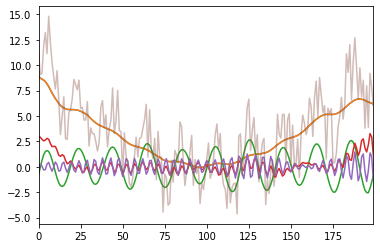

In [0]:
plots(F, 30)

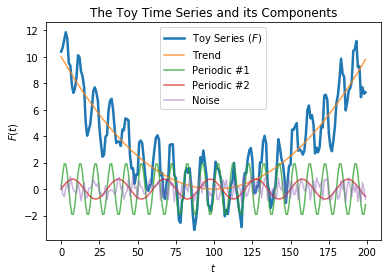

In [0]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2 = 10, 30
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

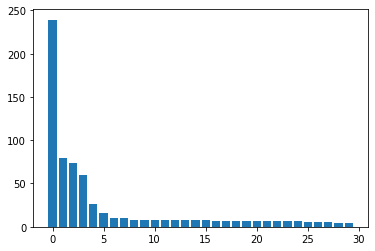

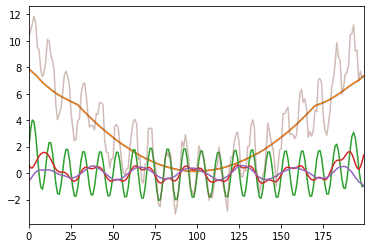

In [0]:
plots(F, 30)

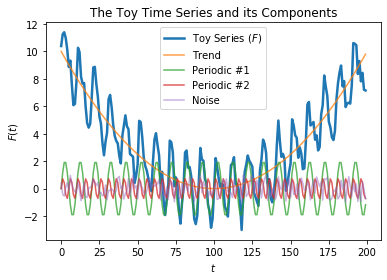

In [0]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2 = 10, 5
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

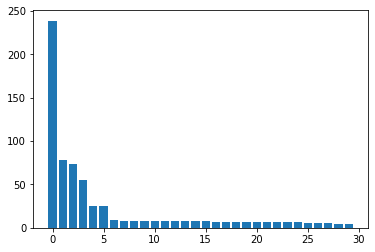

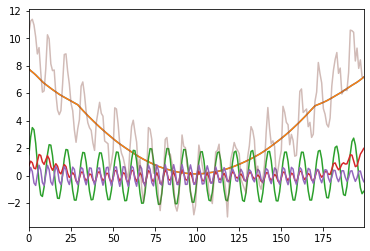

In [0]:
plots(F, 30)

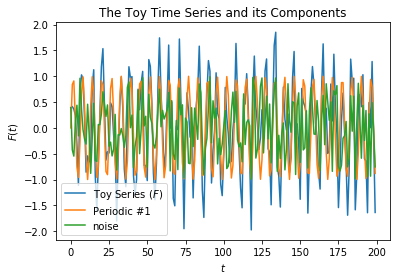

In [0]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
periodic1 = np.sin(t)
F = periodic1  + noise

# Plot everything
plt.plot(t, F)
plt.plot(t, periodic1)
plt.plot(t, noise)
plt.legend(["Toy Series ($F$)", "Periodic #1", "noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

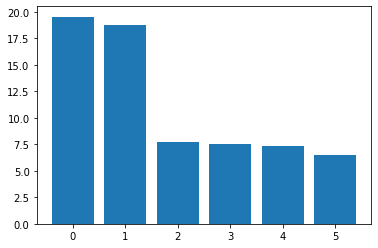

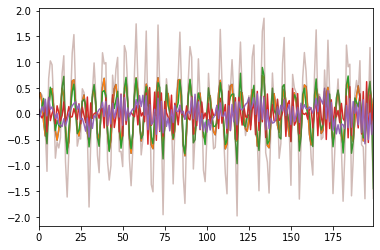

In [0]:
plots(F, 6)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
data = pd.read_csv("/content/gdrive/My Drive/SN_m_tot_V2.0.csv")
#data = np.array(data)
print(data)
print(len(data))

       96.7
0     104.3
1     116.7
2      92.8
3     141.7
4     139.2
...     ...
3246    0.5
3247    1.1
3248    0.4
3249    0.5
3250    1.6

[3251 rows x 1 columns]
3251


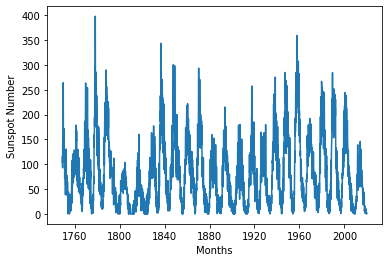

In [6]:
time = pd.date_range('1/1/1749', '12/1/2019', freq='1M')
first_col = np.arange(0, 3252, 1)
cols = [first_col, data]
accel_1 = (data**2).sum(axis=1)**0.5
#accel_1.index /= 50

plt.plot(time, accel_1)
plt.xlabel(r"Months")
plt.ylabel("Sunspot Number")
plt.title("");

In [0]:
start = 0
end =  3252
window = 143
accel_ssa = SSA(accel_1.loc[start:end], window)

<BarContainer object of 50 artists>

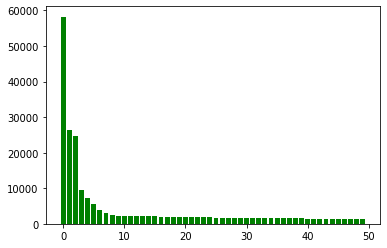

In [8]:
height = accel_ssa.sigma()[0:50]
x = np.arange(50)
plt.bar(x, height, color="green")

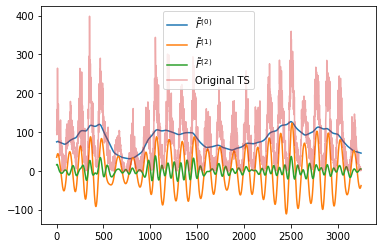

In [9]:
accel_ssa.reconstruct(0).plot()
accel_ssa.reconstruct([1,2]).plot()
accel_ssa.reconstruct([3,4]).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("")
plt.xlabel(r"")
plt.ylabel("")

legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend);

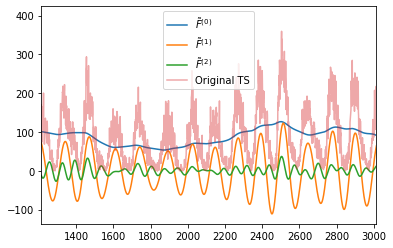

In [10]:
accel_ssa.reconstruct(0).plot()
accel_ssa.reconstruct([1,2]).plot()
accel_ssa.reconstruct([3,4]).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("")
plt.xlabel(r"")
plt.ylabel("")
plt.xlim(1213, 3013)
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend);

In [11]:
data = pd.read_csv("/content/gdrive/My Drive/Daily_temp.csv")
print(data)
print(len(data))

      data
0       13
1       11
2       15
3       19
4       15
...    ...
8396    13
8397     0
8398     0
8399     0
8400    13

[8401 rows x 1 columns]
8401


In [12]:
daily_data = []
sum = 0
num = 0
for i in range(8400):
  sum += data['data'][i]
  num += 1
  if (num == 10):
    daily_data.append(sum / 10)
    sum = 0
    num = 0
daily_data = pd.Series(daily_data)
print(len(daily_data))

840


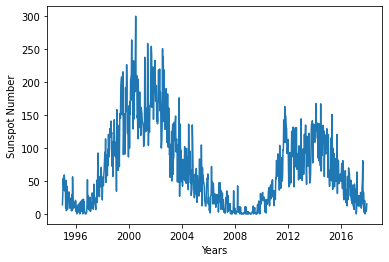

In [13]:
time = pd.date_range('1/1/1995', '12/30/2017', freq='10D')
first_col = np.arange(0, 840, 1)
cols = [first_col, daily_data]
#accel_1 = (daily_data**2).sum(axis=1)**0.5
#accel_1.index /= 50

plt.plot(time, daily_data)
plt.xlabel(r"Years")
plt.ylabel("Sunspot Number")
plt.title("");

In [14]:
data = pd.read_csv("/content/gdrive/My Drive/sea_level.txt", sep='\s+')
print(data)
print(len(data))

     f     s         time      fo  ...      n       t      e     tw
0    0    11  1993.011526  466462  ... -37.24   92.66 -37.02 -37.55
1    0    12  1993.038692  460889  ... -40.34   95.39 -38.19 -38.06
2    0    13  1993.065858  472123  ... -40.16   92.29 -38.27 -37.60
3    0    14  1993.093025  421377  ... -41.89   96.19 -38.54 -37.45
4    0    15  1993.120191  459548  ... -36.85   94.63 -37.83 -36.44
..  ..   ...          ...     ...  ...    ...     ...    ...    ...
987  0   999  2019.835246  469942  ...  60.42  109.48  63.02  57.71
988  0  1000  2019.862412  470521  ...  65.50  111.65  62.98  58.13
989  0  1001  2019.889579  476291  ...  64.12  111.73  62.92  58.73
990  0  1002  2019.916745  477364  ...  62.46  110.15  62.87  59.46
991  0  1003  2019.943911  480803  ...  61.19  108.91  62.83  60.28

[992 rows x 12 columns]
992


In [15]:
data = data.loc[data['time'] >= 1995.0]
data = data.loc[data['time'] < 2018]
print(data)
print(len(data))

     f    s         time      fo         fi  ...     ei      n       t      e     tw
74   0   85  1995.021821  469486  338088.81  ... -25.29 -23.22   95.83 -24.74 -25.00
75   0   86  1995.048988  470724  339167.81  ... -25.56 -26.57   91.66 -25.00 -24.65
76   0   87  1995.076154  469783  338816.19  ... -26.38 -22.53   94.70 -25.81 -24.97
77   0   88  1995.103320  467616  336552.50  ... -27.23 -27.38   91.66 -26.66 -25.45
78   0   89  1995.130486  468762  337824.59  ... -27.84 -32.14   90.93 -27.26 -25.77
..  ..  ...          ...     ...        ...  ...    ...    ...     ...    ...    ...
915  0  927  2017.879283  476076  346501.59  ...  47.44  53.72   98.82  54.24  49.78
916  0  928  2017.906449  480311  347545.09  ...  47.03  55.37  100.79  53.86  50.15
917  0  929  2017.933616  478472  345450.09  ...  46.17  54.30  100.66  53.02  50.14
918  0  930  2017.960782  482576  348484.91  ...  44.95  53.45   99.48  51.80  49.78
919  0  931  2017.987948  484683  349239.00  ...  43.60  48.99   

In [16]:
first_part = data['si'][0:840]
second_part = data['ei'][0:840]
third_part = data['tw'][0:840]
print(first_part)
print(second_part)
print(third_part)

74    -23.77
75    -27.13
76    -23.10
77    -27.96
78    -32.72
       ...  
909    46.71
910    44.28
911    45.10
912    46.45
913    47.48
Name: si, Length: 840, dtype: float64
74    -25.29
75    -25.56
76    -26.38
77    -27.23
78    -27.84
       ...  
909    44.94
910    45.49
911    45.99
912    46.54
913    47.07
Name: ei, Length: 840, dtype: float64
74    -25.00
75    -24.65
76    -24.97
77    -25.45
78    -25.77
       ...  
909    47.38
910    47.25
911    47.34
912    47.75
913    48.41
Name: tw, Length: 840, dtype: float64


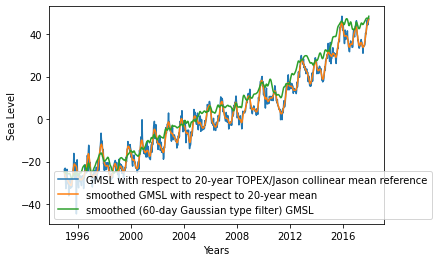

In [17]:
time = pd.date_range('1/1/1995', '12/30/2017', freq='10D')
first_col = np.arange(0, 840, 1)
first_cols = [first_col, first_part]
second_cols = [first_col, second_part]
third_cols = [first_col, third_part]

plt.plot(time, first_part)
plt.plot(time, second_part)
plt.plot(time, third_part)
plt.legend(["GMSL with respect to 20-year TOPEX/Jason collinear mean reference", "smoothed GMSL with respect to 20-year mean", "smoothed (60-day Gaussian type filter) GMSL"])
plt.xlabel(r"Years")
plt.ylabel("Sea Level")
plt.title("");

In [0]:
def window_print(window, daily_data1, name):
  start = 0
  end =  840
  arr_size = min(window, 100);
  data_ssa = SSA(daily_data1.loc[start:end], window)


  height = data_ssa.sigma()[0:arr_size]
  x = np.arange(arr_size)
  orig_time = pd.date_range('1/1/1995', '12/30/2017', freq='10D')
  time = orig_time[0:len(data_ssa.reconstruct(0))]
  plt.bar(x, height, color="green")
  plt.xlabel(r"Index")
  plt.ylabel("Singular value")
  plt.show()
  plt.plot(time, daily_data1[0:len(data_ssa.reconstruct(0))])
  plt.plot(time, data_ssa.reconstruct(0))
  plt.plot(time, data_ssa.reconstruct(1))
  plt.plot(time, data_ssa.reconstruct(2))
  #plt.plot(time, data_ssa.reconstruct(3))
  plt.title("")
  plt.xlabel(r"Years")
  plt.ylabel(name)

  legend = ["Original TS"] + [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(4)]
  plt.legend(legend);
  plt.show()

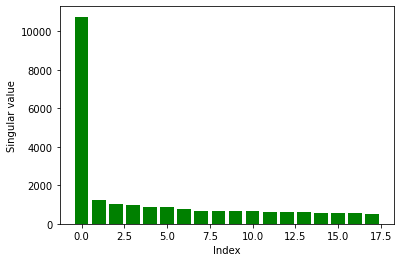

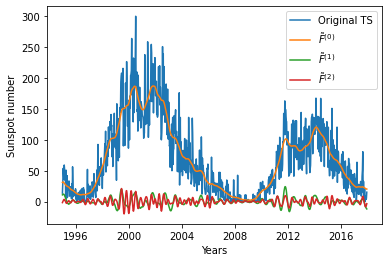

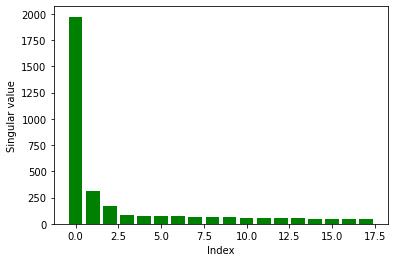

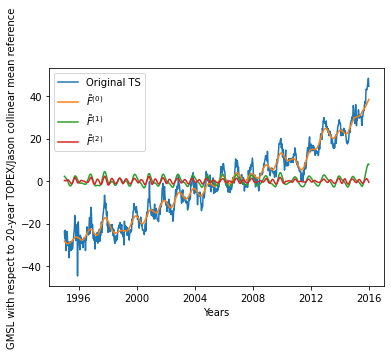

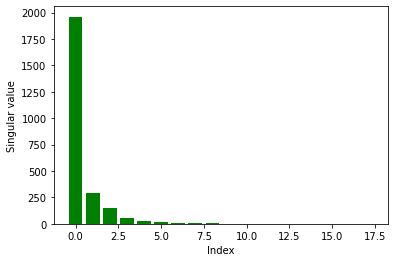

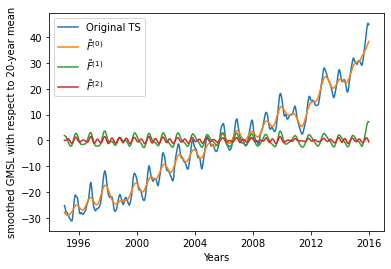

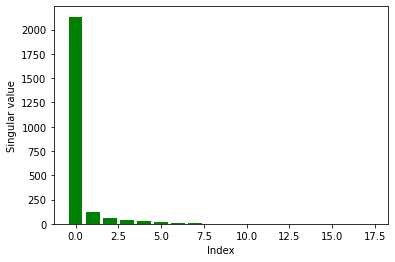

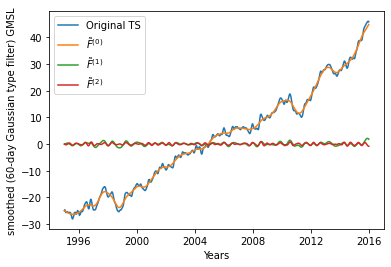

In [20]:
window_print(18, daily_data, "Sunspot number")
window_print(18, first_part, "GMSL with respect to 20-year TOPEX/Jason collinear mean reference")
window_print(18, second_part, "smoothed GMSL with respect to 20-year mean")
window_print(18, third_part, "smoothed (60-day Gaussian type filter) GMSL")

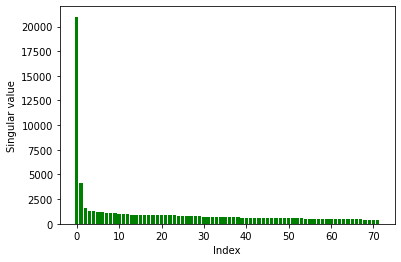

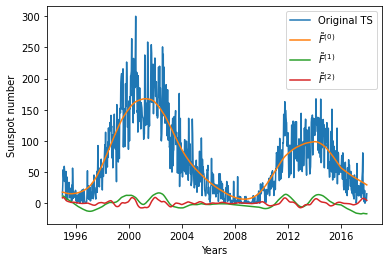

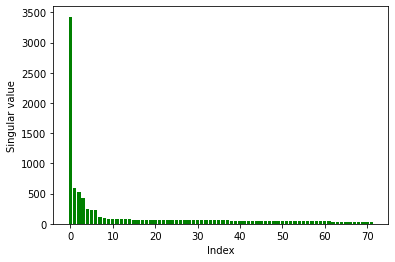

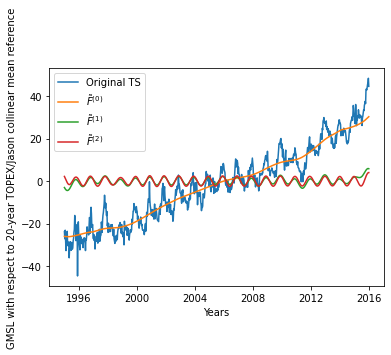

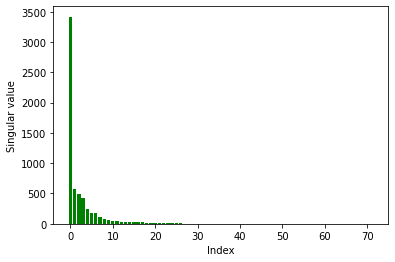

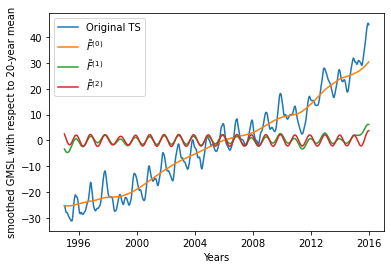

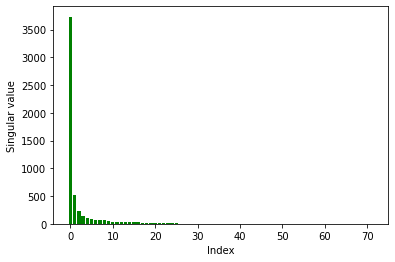

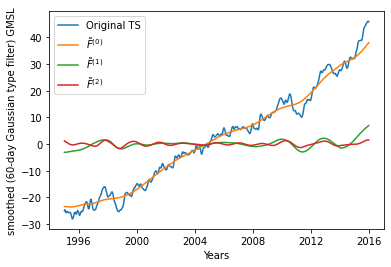

In [21]:
window_print(72, daily_data, "Sunspot number")
window_print(72, first_part, "GMSL with respect to 20-year TOPEX/Jason collinear mean reference")
window_print(72, second_part, "smoothed GMSL with respect to 20-year mean")
window_print(72, third_part, "smoothed (60-day Gaussian type filter) GMSL")

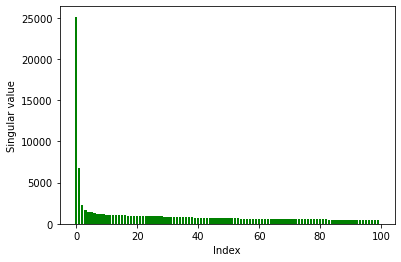

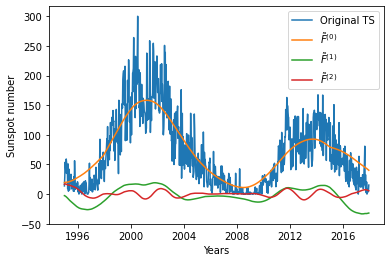

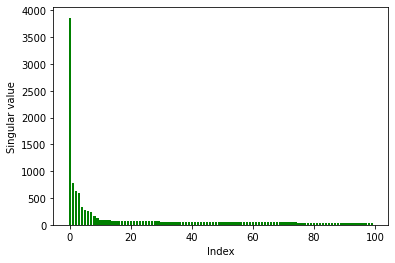

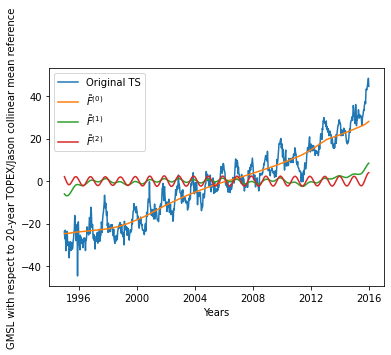

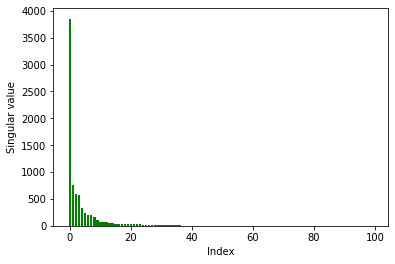

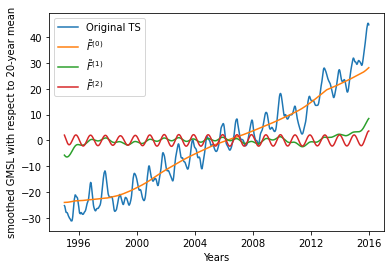

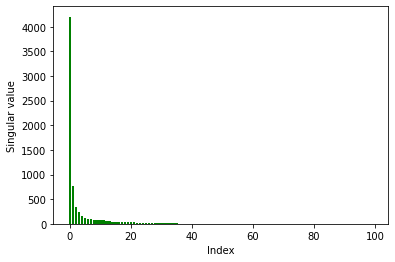

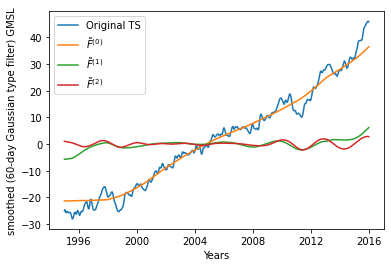

In [89]:
window_print(108, daily_data, "Sunspot number")
window_print(108, first_part, "GMSL with respect to 20-year TOPEX/Jason collinear mean reference")
window_print(108, second_part, "smoothed GMSL with respect to 20-year mean")
window_print(108, third_part, "smoothed (60-day Gaussian type filter) GMSL")

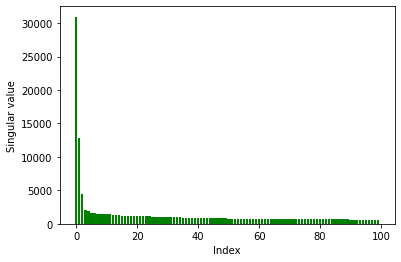

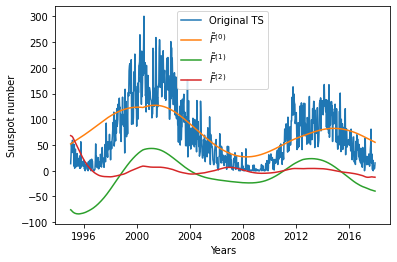

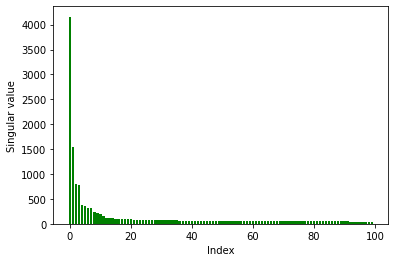

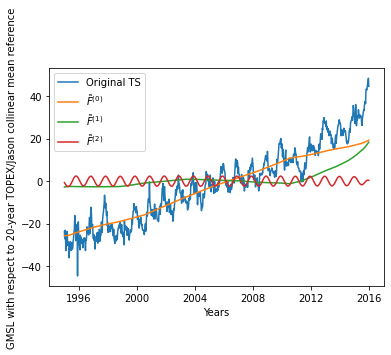

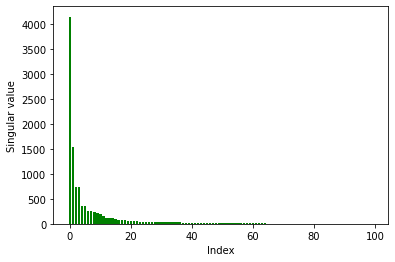

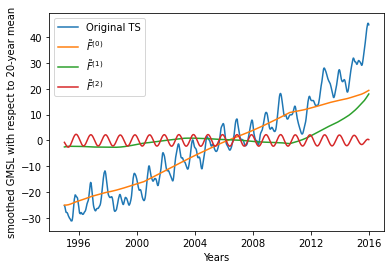

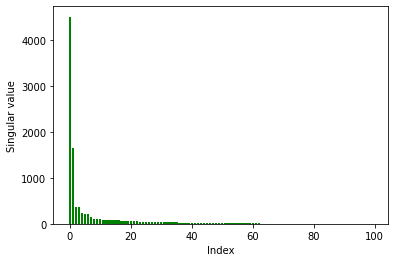

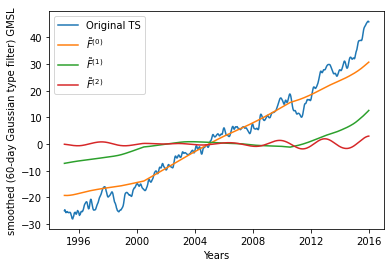

In [92]:
window_print(200, daily_data, "Sunspot number")
window_print(200, first_part, "GMSL with respect to 20-year TOPEX/Jason collinear mean reference")
window_print(200, second_part, "smoothed GMSL with respect to 20-year mean")
window_print(200, third_part, "smoothed (60-day Gaussian type filter) GMSL")

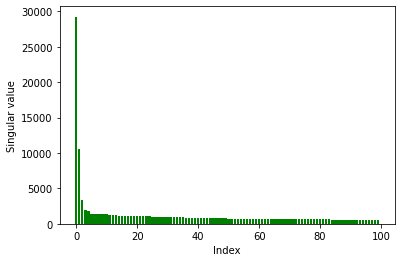

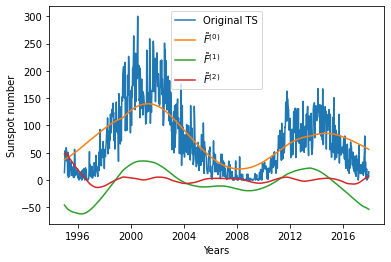

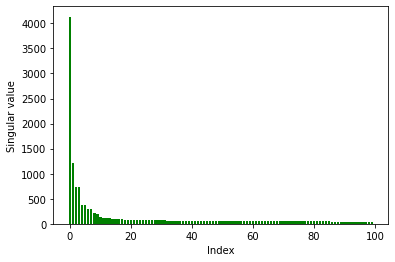

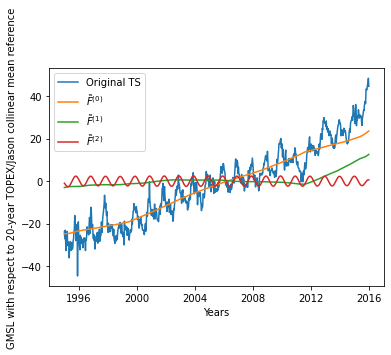

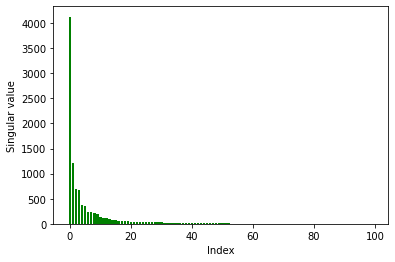

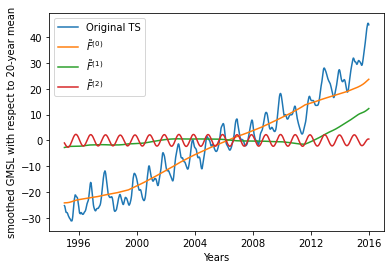

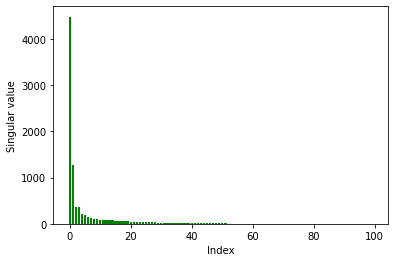

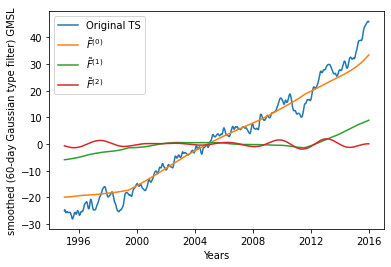

In [90]:
window_print(162, daily_data, "Sunspot number")
window_print(162, first_part, "GMSL with respect to 20-year TOPEX/Jason collinear mean reference")
window_print(162, second_part, "smoothed GMSL with respect to 20-year mean")
window_print(162, third_part, "smoothed (60-day Gaussian type filter) GMSL")

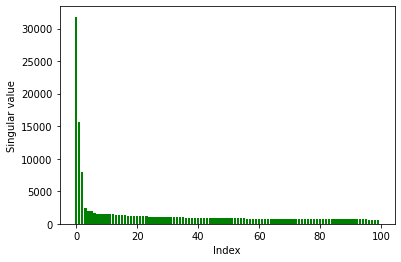

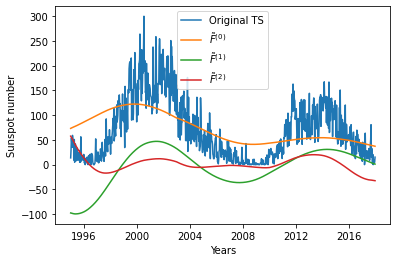

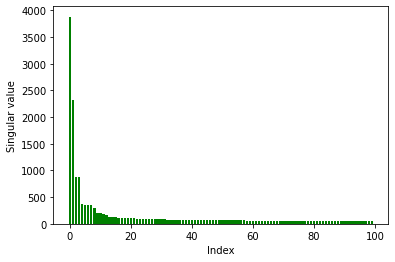

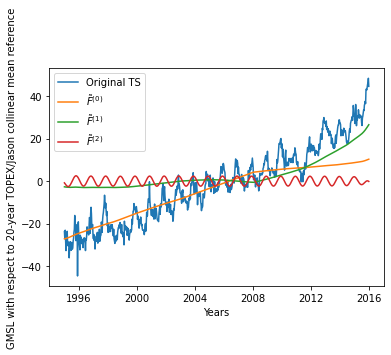

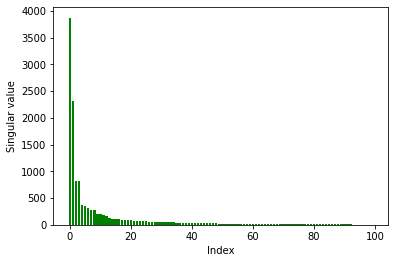

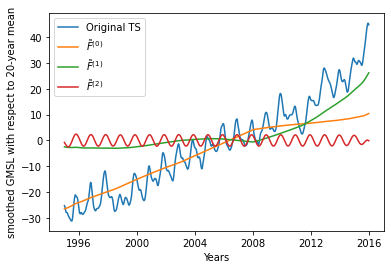

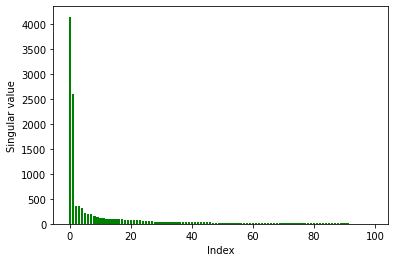

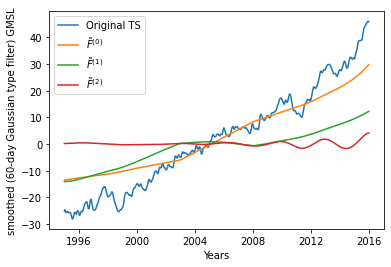

In [93]:
window_print(292, daily_data, "Sunspot number")
window_print(292, first_part, "GMSL with respect to 20-year TOPEX/Jason collinear mean reference")
window_print(292, second_part, "smoothed GMSL with respect to 20-year mean")
window_print(292, third_part, "smoothed (60-day Gaussian type filter) GMSL")

In [0]:
from numpy.fft import rfft, rfftfreq
from numpy import abs as np_abs

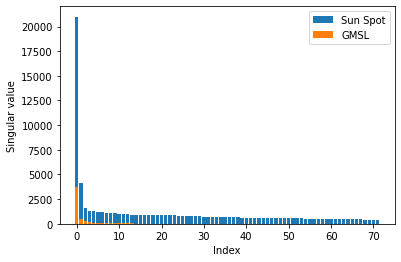

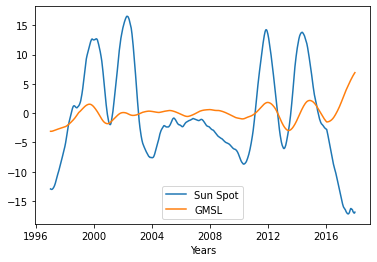

In [79]:
#окно в 2 года, применение преобразования Фурье
start = 0
end =  840
window = 72
arr_size = min(window, 100);
data_ssa = SSA(daily_data.loc[start:end], window)
ocean_ssa = SSA(third_part.loc[start:end], window)

height1 = data_ssa.sigma()[0:arr_size]
height2 = ocean_ssa.sigma()[0:arr_size]
x = np.arange(arr_size)
orig_time = pd.date_range('1/1/1995', '12/30/2017', freq='10D')
time = orig_time[len(orig_time) - len(ocean_ssa.reconstruct(0)):]
plt.bar(x, height1)
plt.bar(x, height2)
plt.xlabel(r"Index")
plt.ylabel("Singular value")
legend = ["Sun Spot"] + ["GMSL"]
plt.legend(legend)
plt.show()

plt.plot(time, (data_ssa.reconstruct(1))[len(orig_time) - len(ocean_ssa.reconstruct(0)):])
plt.plot(time, ocean_ssa.reconstruct(1))
plt.title("")
plt.xlabel(r"Years")
legend = ["Sun Spot"] + ["GMSL"]
plt.legend(legend);
plt.show()

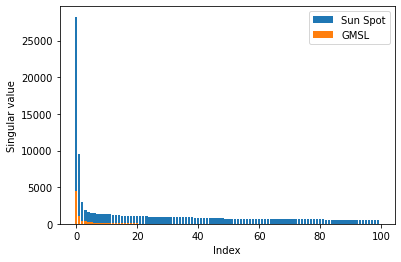

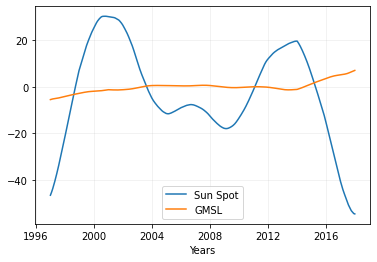

In [81]:
#окно в 4 года, применение преобразования Фурье
start = 0
end =  840
window = 146
arr_size = min(window, 100);
data_ssa = SSA(daily_data.loc[start:end], window)
ocean_ssa = SSA(third_part.loc[start:end], window)

height1 = data_ssa.sigma()[0:arr_size]
height2 = ocean_ssa.sigma()[0:arr_size]
x = np.arange(arr_size)
orig_time = pd.date_range('1/1/1995', '12/30/2017', freq='10D')
time = orig_time[len(orig_time) - len(ocean_ssa.reconstruct(0)):]
plt.bar(x, height1)
plt.bar(x, height2)
plt.xlabel(r"Index")
plt.ylabel("Singular value")
legend = ["Sun Spot"] + ["GMSL"]
plt.legend(legend)
plt.show()

plt.plot(time, (data_ssa.reconstruct(1))[len(orig_time) - len(ocean_ssa.reconstruct(0)):])
plt.plot(time, ocean_ssa.reconstruct(1))
plt.grid(alpha=0.2)
plt.title("")
plt.xlabel(r"Years")
legend = ["Sun Spot"] + ["GMSL"]
plt.legend(legend);
plt.show()

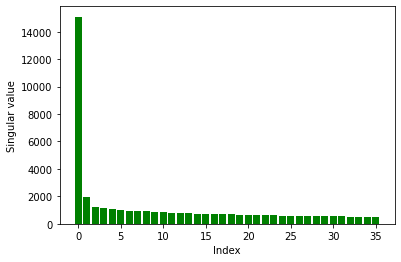

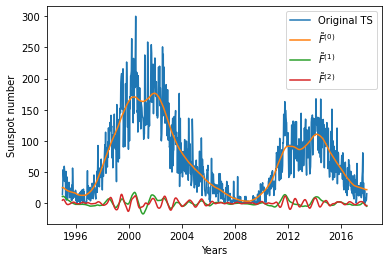

In [91]:
window_print(36, daily_data, "Sunspot number")

In [0]:
f_rolling_mean = first_part.rolling(window=36).mean()[109:]
s_rolling_mean = second_part.rolling(window=36).mean()[109:]
t_rolling_mean = third_part.rolling(window=36).mean()[109:]

In [0]:
start = 0
end =  731
window = 18
arr_size_ = min(window, 100)
f_ssa_ = SSA(f_rolling_mean, window)
s_ssa_ = SSA(s_rolling_mean, window)
t_ssa_ = SSA(t_rolling_mean, window)

In [0]:
daily_data_ = daily_data[109:]
sun_ssa_ = SSA(daily_data_, window)

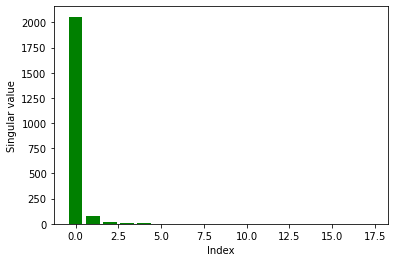

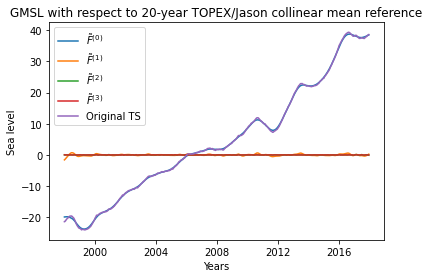

In [0]:
height = f_ssa_.sigma()[0:arr_size_]
x = np.arange(arr_size_)
time = pd.date_range('1/1/1998', '12/30/2017', freq='10D')
plt.bar(x, height, color="green")
plt.xlabel(r"Index")
plt.ylabel("Singular value")
plt.show()
plt.plot(time, f_ssa_.reconstruct(0))
plt.plot(time, f_ssa_.reconstruct([1,2]))
plt.plot(time, f_ssa_.reconstruct([3,4]))
plt.plot(time, f_ssa_.reconstruct([5,6]))
plt.plot(time, f_rolling_mean)
plt.title("GMSL with respect to 20-year TOPEX/Jason collinear mean reference")
plt.xlabel(r"Years")
plt.ylabel("Sea level")

legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(4)] + ["Original TS"]
plt.legend(legend);

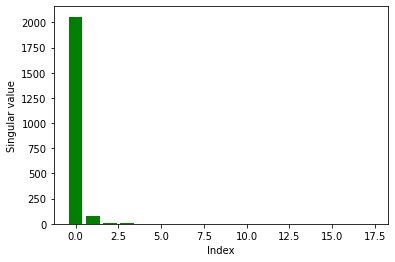

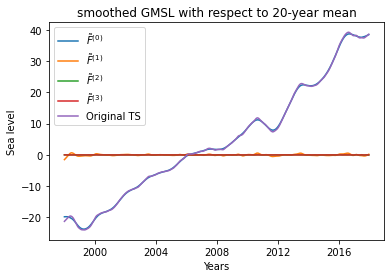

In [0]:
height = s_ssa_.sigma()[0:arr_size_]
x = np.arange(arr_size_)
time = pd.date_range('1/1/1998', '12/30/2017', freq='10D')
plt.bar(x, height, color="green")
plt.xlabel(r"Index")
plt.ylabel("Singular value")
plt.show()
plt.plot(time, s_ssa_.reconstruct(0))
plt.plot(time, s_ssa_.reconstruct([1,2]))
plt.plot(time, s_ssa_.reconstruct([3,4]))
plt.plot(time, s_ssa_.reconstruct([5,6]))
plt.plot(time, s_rolling_mean)
plt.title("smoothed GMSL with respect to 20-year mean")
plt.xlabel(r"Years")
plt.ylabel("Sea level")

legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(4)] + ["Original TS"]
plt.legend(legend);

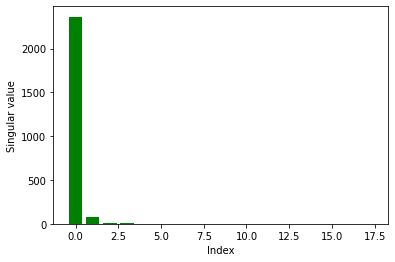

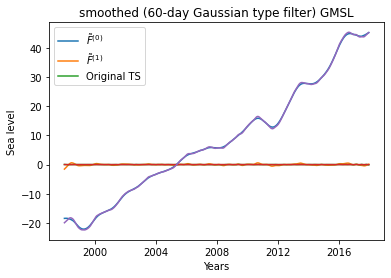

In [0]:
height = t_ssa_.sigma()[0:arr_size_]
x = np.arange(arr_size_)
time = pd.date_range('1/1/1998', '12/30/2017', freq='10D')
plt.bar(x, height, color="green")
plt.xlabel(r"Index")
plt.ylabel("Singular value")
plt.show()
plt.plot(time, t_ssa_.reconstruct(0))
plt.plot(time, t_ssa_.reconstruct([1,2]))
plt.plot(time, t_ssa_.reconstruct([3,4]))
plt.plot(time, t_ssa_.reconstruct([5,6]))
plt.plot(time, t_rolling_mean)
plt.title("smoothed (60-day Gaussian type filter) GMSL")
plt.xlabel(r"Years")
plt.ylabel("Sea level")

legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(2)] + ["Original TS"]
plt.legend(legend);

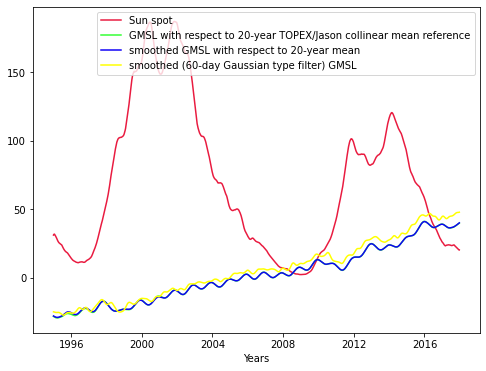

In [0]:
plt.figure(figsize=(8,6))
time = pd.date_range('1/1/1995', '12/30/2017', freq='10D')
#plt.plot(time, daily_data, color="#ff4466")
#plt.plot(time, first_part, color="lime")
#plt.plot(time, second_part, color="blue")
#plt.plot(time, third_part, color="yellow")
plt.plot(time, sun_ssa.reconstruct(0), color="#E91B40")
#plt.plot(time, sun_ssa.reconstruct([1,2]), color="red")
#plt.plot(time, sun_ssa.reconstruct([3,4]), color="#f6a1b0")
plt.plot(time, f_ssa.reconstruct(0), color="#32ff32")
#plt.plot(time, f_ssa.reconstruct([1,2]), color="#7eff7e")
#plt.plot(time, f_ssa.reconstruct([3,4]), color="#ddffdd")
plt.plot(time, s_ssa.reconstruct(0), color="#0f00f6")
#plt.plot(time, s_ssa.reconstruct([1,2]), color="#4135ff")
#plt.plot(time, s_ssa.reconstruct([3,4]), color="#8982ff")
plt.plot(time, t_ssa.reconstruct(0) + t_ssa.reconstruct([1,2]), color="yellow")
#plt.plot(time, t_ssa.reconstruct([1,2]), color="#feff3d")
#plt.plot(time, t_ssa.reconstruct([3,4]), color="#ffc824")

plt.xlabel(r"Years")

plt.legend(["Sun spot", "GMSL with respect to 20-year TOPEX/Jason collinear mean reference", "smoothed GMSL with respect to 20-year mean", "smoothed (60-day Gaussian type filter) GMSL"])

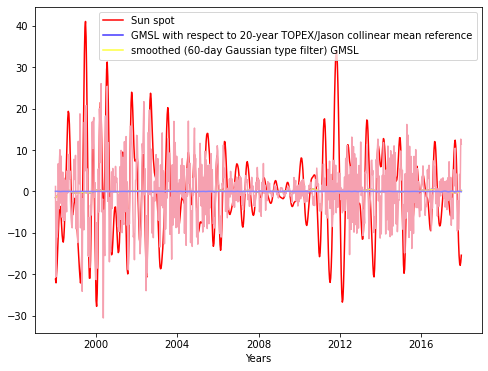

In [0]:
plt.figure(figsize=(8,6))
time = pd.date_range('1/1/1998', '12/30/2017', freq='10D')

plt.plot(time, sun_ssa_.reconstruct([1,2]), color="red")
plt.plot(time, s_ssa_.reconstruct([1,2]), color="#4135ff")
plt.plot(time, t_ssa_.reconstruct([1,2]), color="#feff3d")
#plt.plot(time, daily_data_, color="#ff4466")
#plt.plot(time, f_rolling_mean, color="lime")
#plt.plot(time, s_rolling_mean, color="blue")
#plt.plot(time, t_rolling_mean, color="yellow")
#plt.plot(time, sun_ssa_.reconstruct(0), color="#E91B40")
plt.plot(time, sun_ssa_.reconstruct([3,4]), color="#f6a1b0")
#plt.plot(time, f_ssa_.reconstruct(0), color="#32ff32")
#plt.plot(time, f_ssa_.reconstruct([1,2]), color="#7eff7e")
#plt.plot(time, f_ssa_.reconstruct([3,4]), color="#ddffdd")
#plt.plot(time, s_ssa_.reconstruct(0), color="#0f00f6")
plt.plot(time, s_ssa_.reconstruct([3,4]), color="#8982ff")
#plt.plot(time, t_ssa_.reconstruct(0) + t_ssa.reconstruct([1,2]), color="yellow")
#plt.plot(time, t_ssa_.reconstruct([3,4]), color="#ffc824")

plt.xlabel(r"Years")

plt.legend(["Sun spot", "GMSL with respect to 20-year TOPEX/Jason collinear mean reference", "smoothed (60-day Gaussian type filter) GMSL"])